# Tesco Data Scientiest Test

In [60]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%matplotlib inline

In [47]:
transactions = pd.read_csv('transactions.tsv', delimiter='\t')

# Q1
The mean of the transactions dataset is 

In [48]:
np.mean(transactions['transaction.value'])

286.17605

whereas the median is

In [49]:
np.median(transactions['transaction.value'])

47.275000000000006

There are 2 reasons for this difference. First there are a few very unusual large transactions which should be investigated:

In [50]:
transactions.nlargest(10,'transaction.value')

,transaction.value,gender,store.type
1428,150032.00,Female,Metro
50,100000.00,Female,Extra
1382,11840.25,Female,Extra
1375,3180.76,Male,Extra
667,2502.39,Female,Extra
675,2288.23,Male,Extra
1251,2174.41,Male,Extra
1284,1832.73,Female,Extra
481,1701.38,Female,Extra
1499,1615.51,Female,Extra


Removing the 3 largest entries and plotting a histogram we see a typical Gamma-like skewed distribution which is the second reason for the difference in mean and median. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f9b5860>]],
      dtype=object)

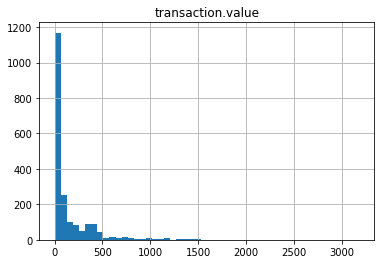

In [51]:
big_trans_ids = transactions.nlargest(3,'transaction.value').index
transactions2 = transactions[~transactions.index.isin(big_trans_ids)]
transactions2.hist(bins=50)

Using a log plot on the x-axis we see that there are actually several peaks in the distribution with the main one being at 1.6 (which equates to £40 under log base 10) and several more peaks for larger values.

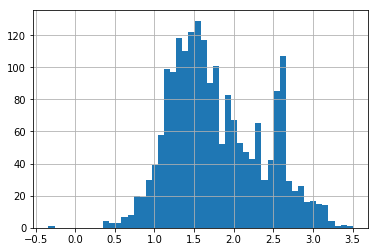

In [52]:
np.log10(transactions2['transaction.value']).hist(bins=50)

# Q2
To determine if there is a significant difference in the average spend we will assume that each transaction is an independent random variable drawn from some (unknown) probability distribution. We can then use the central limit theorem that any sum of independent random variables is approximated by a standard normal distribution. Given the sample mean and standard deviation of transaction value for each store type we can use a t-test on pairs of store type means to test for significant difference. Note: the 3 largest values have been removed from consideration as outliers that need to be investigated.

In [53]:
transactions2.groupby('store.type').agg(['mean','std'])

transaction.value            
                        mean         std
store.type                              
Express            86.349468  191.863120
Extra             256.231125  387.696657
Metro             113.176605  218.942121
Superstore        155.166490  215.615642

We can use the scipy t-test ```ttest_ind(...)``` to perform a 2-sided t-test for each of the pairs of store types. The results below indicate using 5% (and even a 1%) level there are significant differences in average spend across all store types aparat from Express and Metro.

In [54]:
express    = transactions2[transactions2['store.type'] == 'Express']['transaction.value']
metro      = transactions2[transactions2['store.type'] == 'Metro']['transaction.value']
superstore = transactions2[transactions2['store.type'] == 'Superstore']['transaction.value']
extra      = transactions2[transactions2['store.type'] == 'Extra']['transaction.value']
pd.DataFrame({'Pairs': ['express-metro', 'express-superstore', 
                        'express-extra', 'metro-superstore', 
                        'metro-extra',   'superstore-extra'],
              'p-value': [ttest_ind(express, metro)[1], ttest_ind(express, superstore)[1],
                          ttest_ind(express, extra)[1], ttest_ind(metro, superstore)[1],
                          ttest_ind(metro, extra)[1], ttest_ind(superstore, extra)[1]]
             })

,Pairs,p-value
0,express-metro,8.742951e-02
1,express-superstore,2.224495e-06
2,express-extra,2.382553e-11
3,metro-superstore,7.213495e-04
4,metro-extra,9.507566e-12
5,superstore-extra,5.935764e-09


Methodological note: comparing several sets of variables like this using a standard t-test can be problematic as the t-values ought to be adjusted e.g. using Bonferroni method. However given the magnitudes of the the p-values we wouldn't get a different outcome.

# Q3
The key issue with this type of problem is the highly imbalanced dataset. Very few people click on the content, in the case of content_1 ~1%

In [55]:
train = pd.read_csv('content_train.tsv', delimiter='\t')
test = pd.read_csv('content_test.tsv',  delimiter='\t')
train_content1 = train[~train['content_1'].isnull()]
train_content1.groupby('content_1').count()['customer.id']

content_1
0.0    45520
1.0      502
Name: customer.id, dtype: int64

To approach the problem we will use a Random Forest classifier, split the data randomly 80:20, train on the 80% and valiate the approach on 20%. The resulting model is then used to predict on the test data. There are a number of different metrics that can be used to measure performance on models for an unbalanced dataset, a commonly used one is Receiver Operating Characterstic (ROC).

In [56]:
clf = RandomForestClassifier(n_estimators=100,max_depth=4, class_weight={0.0: 99, 1.0: 1})
clf

RandomForestClassifier(bootstrap=True, class_weight={0.0: 99, 1.0: 1},
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [57]:
# calculate 'dummy' variables for gender, affluence and country across train and test
test['content_1'] = 1.0 # need same columns for the next line
data = pd.concat([train_content1, test], sort=True)
data = pd.get_dummies(data)
train_content1 = data[:len(train_content1)]
test           = data[len(train_content1):]
train_train_content1, val_train_content1 = train_test_split(train_content1, test_size=0.2)

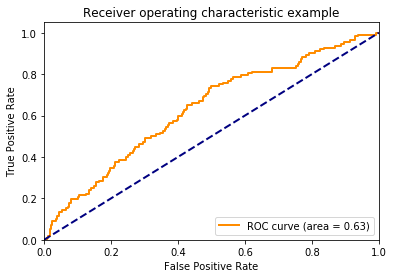

In [58]:
X_cols = train_train_content1.columns[10:]
y = train_train_content1['content_1']
X = train_train_content1[X_cols]
y_val = val_train_content1['content_1']
X_val = val_train_content1[X_cols]
X_test = test[X_cols]
clf.fit(X,y)
y_pred = clf.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
thresholds

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [59]:
test_pred = clf.predict_proba(X_test)[:,1]
customer_id = test['customer.id']
preds = pd.DataFrame({'customer.id': customer_id, 'prediction': test_pred})
preds.to_csv('content_1_predictions.csv')

# Q4
A system to determine what content to show a user could use a real-time predictive model using, for example, Random Forests.

### Training
*Assumption: Labelled historical production data is available to an Apache Spark system*
    
Using Apache Spark MLLib train a number of Random Forest (RF) models on the historical data to predict each of the different content interaction labels. Export the models as PMML (Predictive Model Markup Language).

### Real-time model scoring
Model scoring is run as a REST-based service e.g. [openscoring](https://github.com/openscoring/openscoring). The RF models are uploaded to the open scoring service using provided APIs. At runtime scoring is performed by a REST call to the openscoring service. Performance of the model is monitored via the openscoring metrics API.

Multipe openscoring instances fronted by a load-balancer can be used to provide resilience and scaling.

### Model updating
Blue-green updating of the model can be supported by versioning the model using openscoring APIs and building support for calling different model versions into the REST calling code. When a new version of the model is being trialled both the current and new version can be evaluated and the results compared off-line by data scientists. When the performance of the new model is judged to be satisfactory the old model can be retired.